# Finite Volume Burgers

Copyright (C) 2010-2020 Luke Olson<br>
Copyright (C) 2020 Andreas Kloeckner

<details>
<summary>MIT License</summary>
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</details>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib import animation
from IPython.display import HTML

In [2]:
def gaussian(x):
    u = np.exp(-100 * (x - 0.25)**2)
    return u


def step(x):
    u = np.zeros(x.shape)
    for j in range(len(x)):
        if (x[j] >= 0.6) and (x[j] <= 0.8):
            u[j] = 1.0

    return u

def g1(x):
    return 1+gaussian(x)

def g2(x):
    return 1+gaussian(x) + step(x)

g = g1

tsteps = 250
    dx = 0.00609756
lambda = 0.95


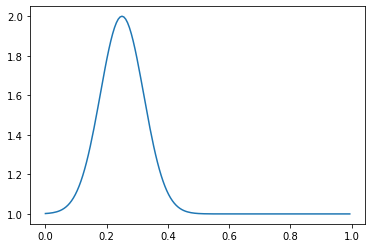

In [3]:
nx = 164
x = np.linspace(0, 1, nx, endpoint=False)
dx = x[1] - x[0]
xx = np.linspace(0, 1, 1000, endpoint=False)

lmbda = 0.95
nt = 250
print('tsteps = %d' % nt)
print('    dx = %g' % dx)
print('lambda = %g' % lmbda)

J = np.arange(0, nx)  # all vertices
Jm1 = np.roll(J, 1)
Jp1 = np.roll(J, -1)

plt.plot(x, g(x))

Plot the solution:

In [4]:
if 1:
    # Burgers
    def f(u):
        return u**2/2
    def fprime(u):
        return u
else:
    # advection
    def f(u):
        return u
    def fprime(u):
        return 1+0*u

steps_per_frame = 2

## Part I: Lax-Friedrichs

Implement `rhs` for a Lax-Friedrichs flux:

Recall (local) Lax-Friedrichs:
$$
f^{\ast} (u^{_-}, u^+) = \frac{f (u^-) + f (u^+)}{2} - \frac{\alpha}{2} (u^+ - u^-) 
\quad\text{with}\quad
\alpha = \max \left( |f' (u^-)|, |f' (u^+)| \right).$$
Recall FV:
$$ \bar{u}_{j,\ell+1} = \bar{u}_{j,\ell} - \frac{h_t}{h_x} (f (u_{j + 1 / 2,\ell}) -
   f (u_{j - 1 / 2,\ell})) . $$


In [5]:
#clear
def rhs(u):
    uplus = u[Jp1]
    uminus = u[J]
    alpha = np.maximum(np.abs(fprime(uplus)), np.abs(fprime(uminus)))
    # right-looking, between J and Jp1
    fluxes = (
        (f(uplus)+f(uminus))/2
        - alpha/2*(uplus-uminus)
        )
    return - 1/dx*(fluxes[J]-fluxes[Jm1])

In [6]:
u = g(x)

def timestepper(n):
    for i in range(steps_per_frame):
        dt = dx*lmbda/np.max(np.abs(u))
        u[:] = u + dt*rhs(u)
                       
    line.set_data(x, u)
    return line

fig = plt.figure(figsize=(5,5))
line, = plt.plot(x, u)

ani = animation.FuncAnimation(
    fig, timestepper,
    frames=nt//steps_per_frame,
    interval=30)
html = HTML(ani.to_jshtml())
plt.clf()
html

<Figure size 360x360 with 0 Axes>

## Part II: Second-Order Reconstruction

First, need a second-order time integrator:

In [7]:
def rk2_step(dt, u, rhs):
    k1 = rhs(u)
    k2 = rhs(u+dt*k1)
    return u+0.5*dt*(k1+k2)

Now upgrade the reconstruction to second order. 

**NOTE:** It's OK to assume (here!) that the wind blows from the left (/to the right) to simplify upwinding.

In [10]:
#clear
def rhs(u):
    # right-looking, between J and Jp1
    # 2nd order central
    fluxes = f(u[J] + 1/2*(u[Jp1]+u[J]))
    # 2nd order upwind
    # fluxes = f(u[J] + 1/2*(u[J]-u[Jm1]))
    return - 1/dx*(fluxes[J]-fluxes[Jm1])

In [11]:
u = g(x)

def timestepper(n):
    # to simplify upwinding
    assert np.min(u) >= 0
    
    for i in range(steps_per_frame):
        dt = 0.7*dx*lmbda/np.max(np.abs(u))
        u[:] = rk2_step(dt, u, rhs)
                       
    line.set_data(x, u)
    return line

fig = plt.figure(figsize=(5,5))
line, = plt.plot(x, u)

ani = animation.FuncAnimation(
    fig, timestepper,
    frames=nt//steps_per_frame,
    interval=30)
html = HTML(ani.to_jshtml())
plt.clf()
html

<Figure size 360x360 with 0 Axes>